In [87]:
import pandas as pd

In [88]:
df = pd.read_csv(
    "../data/consumption.csv", usecols=["prediction_unit_id", "datetime", "target"]
)[["prediction_unit_id", "datetime", "target"]].rename(
    columns={"prediction_unit_id": "unique_id", "datetime": "ds", "target": "y"}
)
df["ds"] = pd.to_datetime(df["ds"])
df.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [89]:
df["y"] = df["y"].ffill()
df.isna().sum()

unique_id    0
ds           0
y            0
dtype: int64

# Train/Test split

In [90]:
# taking the last 48 hours for test
horizon = 48
for i in df["unique_id"].unique():
    if i == df["unique_id"].unique()[0]:
        df_test = df[df["unique_id"] == i][-horizon:]
        continue
    df_test = pd.concat([df_test, df[df["unique_id"] == i][-horizon:]])

df_test.sort_index(inplace=True)
print(df_test.shape)
df_test.head()

(3312, 3)


,unique_id,ds,y
906150,26,2023-03-28 00:00:00,5.137
906217,26,2023-03-28 01:00:00,4.212
906284,26,2023-03-28 02:00:00,4.917
906351,26,2023-03-28 03:00:00,4.195
906418,26,2023-03-28 04:00:00,4.518


In [91]:
train_idx = [idx for idx in df.index if idx not in df_test.index]
df_train = df.loc[train_idx]
df_train.shape
df_train.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [92]:
df.shape[0] == df_train.shape[0] + df_test.shape[0]

True

In [93]:
df.shape[1] == df_train.shape[1] == df_test.shape[1]

True

# Training

In [94]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [95]:
# col_params = dict(id_col="building_id", time_col="datetime", target_col="consumption")
# col_params

In [96]:
from lightgbm import LGBMRegressor

lgb_params = {
    "verbosity": -1,
    "num_leaves": 512,
}

fcst = MLForecast(
    models={
        "lgb": LGBMRegressor(**lgb_params),
        # 'q75': LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        # 'q25': LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq="h",
    target_transforms=[Differences([24])],
    lags=[i + 1 for i in range(48)],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=["month", "dayofweek", "hour"],
)

# fcst.preprocess(df_train, **col_params).head()
fcst.preprocess(df_train).head()

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag44,lag45,lag46,lag47,lag48,expanding_mean_lag1,rolling_mean_lag24_window_size48,month,dayofweek,hour
5795,0,2021-09-04 23:00:00,-6.630,10.176,-16.948,30.391,7.926,-17.201,-3.185,6.491,...,-8.897,-8.661,-15.113,-2.237,-6.991,4.519704,5.480750,9,5,23
5796,1,2021-09-04 23:00:00,-0.656,4.648,5.220,-13.346,-10.982,-2.404,-1.357,1.997,...,-1.600,-2.184,2.200,-1.378,-0.827,0.645268,0.864937,9,5,23
5797,2,2021-09-04 23:00:00,-35.639,-62.993,5.519,17.114,47.251,-16.126,-23.379,32.545,...,-102.505,-68.646,-42.397,-44.788,-21.684,33.502592,38.503042,9,5,23
5798,3,2021-09-04 23:00:00,-1.100,-4.200,-3.600,-4.900,-17.900,-16.500,-38.600,-10.800,...,-18.700,-17.200,-19.300,-11.700,-5.500,-7.554930,4.497917,9,5,23
5799,4,2021-09-04 23:00:00,-68.429,-83.631,-70.391,-16.480,-11.291,-59.362,-127.090,-178.232,...,-0.884,-46.453,-51.881,27.731,-9.685,-38.533958,21.538812,9,5,23


In [97]:
import time

start = time.time()
# fcst.fit(df_train, **col_params)
fcst.fit(df_train)
end = time.time()
t = end - start
t

6.127051115036011

# Evaluate

In [98]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mae, rmse

In [99]:
df_eval = pd.merge(df_test, fcst.predict(horizon), on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [100]:
error_ref = evaluate(
    df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train  # , **col_params
)
error_ref.drop(columns=["unique_id"]).groupby("metric").mean()

,lgb
metric,
mae,43.295707
mape,0.609863
mase,0.636145
rmse,61.929235


# Error distribution

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

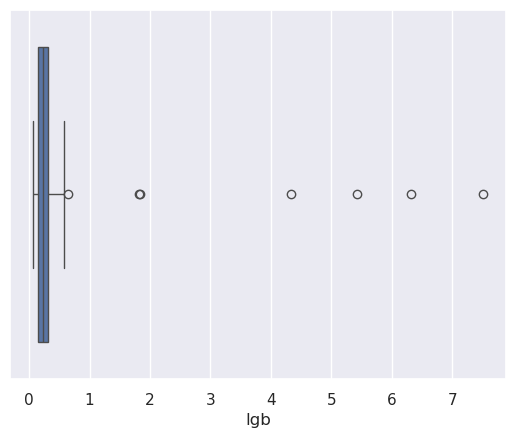

In [102]:
mask = error_ref["metric"] == "mape"
sns.boxplot(x=error_ref.loc[mask, "lgb"])
plt.show()

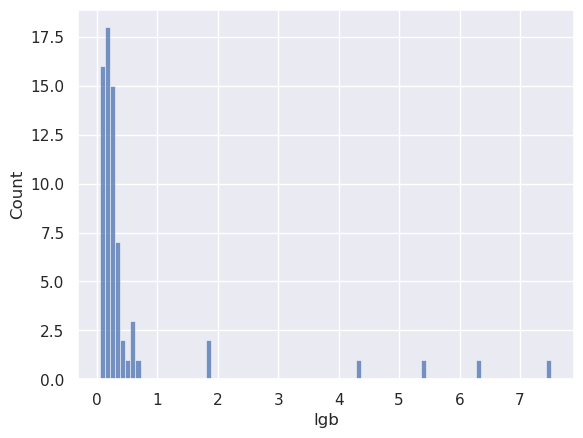

In [103]:
sns.histplot(x=error_ref.loc[mask, "lgb"])
plt.show()

# HPO

## Random Search

In [104]:
fcst = MLForecast(
    models=[],
    freq="h",
    # target_transforms=[Differences([24])],
    lags=[i + 1 for i in range(47)],
    lag_transforms={
        1: [ExpandingMean()],
        1: [RollingMean(window_size=24)],
        24: [RollingMean(window_size=24)],
        # 24: [RollingMean(window_size=48)],
    },
    date_features=["month", "dayofweek", "hour"],
)

fcst.preprocess(df_train).head(1)

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag43,lag44,lag45,lag46,lag47,rolling_mean_lag1_window_size24,rolling_mean_lag24_window_size24,month,dayofweek,hour
2867,0,2021-09-02 23:00:00,120.54,134.986,150.412,152.763,136.13,121.033,80.621,43.428,...,88.184,87.955,91.594,77.691,96.59,87.588333,79.96975,9,3,23


In [105]:
# fcst.preprocess(df_train.groupby("unique_id").head(48)).head(1)

In [106]:
X_train = fcst.preprocess(df_train).rename(columns={"y": "lag0"})
# X_train.head(3)

In [107]:
X_train, y_train = X_train.align(
    df_train.groupby("unique_id")["y"].shift(-24).rename("lead24").dropna(),
    axis=0,
    join="inner",
)
X_train.shape, y_train.shape

((1000965, 55), (1000965,))

In [69]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint

# param_dist = {
#     "learning_rate": np.logspace(-4, -1),
#     "max_depth": np.arange(1, 20, 1),
#     "num_leaves": np.arange(10, 200, 10),
#     "feature_fraction": np.linspace(0.1, 1.0, 10),
#     "subsample": np.linspace(0.1, 1.0, 10)
# }
param_dist = {
    "learning_rate": loguniform(0.0001, 0.1),
    "max_depth": randint(1, 20),
    "num_leaves": randint(10, 200),
    "feature_fraction": uniform(0.1, 1.0),
    "subsample": uniform(0.1, 1.0),
}

lgb = LGBMRegressor(verbosity=0)
tscv = TimeSeriesSplit(n_splits=10)
random_search = RandomizedSearchCV(
    lgb,
    param_distributions=param_dist,
    scoring="neg_mean_absolute_error",
    # n_jobs=-1,
    cv=tscv,
    verbose=1,
    random_state=42,
    n_iter=60,
)
start = time.time()
random_search.fit(X_train.drop(columns=["unique_id", "ds"]), y_train)
end = time.time()
t = end - start

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[LightGBM] [Warning] feature_fraction is set=0.47454011884736247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47454011884736247
[LightGBM] [Warning] feature_fraction is set=0.47454011884736247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47454011884736247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.47454011884736247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47454011884736247
[LightGBM] [Warning] feature_fraction is set=0.47454011884736247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47454011884736247
[LightGBM] [Warning] feature_fraction is set=0.47454011884736247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47454011884736247
[LightGBM] [Warning] feature_fraction is set=0.47454011884736247, colsample_bytree

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0695846277645586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0695846277645586
[LightGBM] [Warning] feature_fraction is set=1.0695846277645586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0695846277645586


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0695846277645586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0695846277645586


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0695846277645586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0695846277645586


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0695846277645586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0695846277645586


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0695846277645586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0695846277645586


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0695846277645586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0695846277645586
[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272719958564209
[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272719958564209


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272719958564209
[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272719958564209
[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272719958564209
[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272719958564209
[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272719958564209
[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8272719958564209
[LightGBM] [Warning] feature_fraction is set=0.8272719958564209, colsample_b

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.8901755405312056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901755405312056
[LightGBM] [Warning] feature_fraction is set=0.8901755405312056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901755405312056


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.8901755405312056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901755405312056


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.8901755405312056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901755405312056


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.8901755405312056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901755405312056


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.8901755405312056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901755405312056


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.8901755405312056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901755405312056
[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500385777897993
[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500385777897993


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500385777897993
[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500385777897993
[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500385777897993
[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500385777897993
[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500385777897993
[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500385777897993
[LightGBM] [Warning] feature_fraction is set=0.9500385777897993, colsample_b

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0717820827209608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0717820827209608
[LightGBM] [Warning] feature_fraction is set=1.0717820827209608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0717820827209608


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0717820827209608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0717820827209608
[LightGBM] [Warning] feature_fraction is set=1.0717820827209608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0717820827209608


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0717820827209608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0717820827209608


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0717820827209608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0717820827209608


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0717820827209608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0717820827209608


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0717820827209608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0717820827209608
[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2480869299533999
[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2480869299533999


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2480869299533999
[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2480869299533999
[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2480869299533999
[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2480869299533999
[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2480869299533999
[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2480869299533999
[LightGBM] [Warning] feature_fraction is set=0.2480869299533999, colsample_b

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.7957843993450822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957843993450822
[LightGBM] [Warning] feature_fraction is set=0.7957843993450822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957843993450822


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.7957843993450822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957843993450822
[LightGBM] [Warning] feature_fraction is set=0.7957843993450822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957843993450822


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.7957843993450822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957843993450822


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.7957843993450822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957843993450822


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.7957843993450822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957843993450822


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.7957843993450822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957843993450822
[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143
[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143
[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143
[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6166358912710143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166358912710143
[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582934536070976
[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582934536070976


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582934536070976
[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582934536070976
[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582934536070976
[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582934536070976
[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582934536070976
[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582934536070976
[LightGBM] [Warning] feature_fraction is set=0.6582934536070976, colsample_b

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0356349942209475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0356349942209475
[LightGBM] [Warning] feature_fraction is set=1.0356349942209475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0356349942209475


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0356349942209475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0356349942209475


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0356349942209475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0356349942209475


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0356349942209475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0356349942209475


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0356349942209475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0356349942209475


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] feature_fraction is set=1.0356349942209475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0356349942209475
[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47228276656174306
[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47228276656174306


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47228276656174306
[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47228276656174306
[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47228276656174306
[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47228276656174306
[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6898708475605438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898708475605438
[LightGBM] [Warning] feature_fraction is set=0.6898708475605438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898708475605438


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6898708475605438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898708475605438
[LightGBM] [Warning] feature_fraction is set=0.6898708475605438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898708475605438


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6898708475605438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898708475605438


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6898708475605438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898708475605438


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6898708475605438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898708475605438


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.6898708475605438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898708475605438
[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343943655104286
[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343943655104286


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343943655104286
[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343943655104286
[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343943655104286
[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343943655104286
[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343943655104286
[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343943655104286
[LightGBM] [Warning] feature_fraction is set=0.5343943655104286, colsample_b

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.868554014306309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.868554014306309
[LightGBM] [Warning] feature_fraction is set=0.868554014306309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.868554014306309


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.868554014306309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.868554014306309


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.868554014306309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.868554014306309


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.868554014306309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.868554014306309


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.868554014306309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.868554014306309


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=0.868554014306309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.868554014306309
[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486
[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486
[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486
[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] feature_fraction is set=1.0148643902204486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0148643902204486
[LightGBM] [Warning] feature_fraction is set=0.5281841483173143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5281841483173143
[LightGBM] [Warning] feature_fraction is set=0.5281841483173143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5281841483173143


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-2ghvrlh_/lightgbm_4db663d9c4564223b21718b9bba4952e/src/io/config_auto.cpp, line 365 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5281841483173143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5281841483173143
[LightGBM] [Warning] feature_fraction is set=0.5281841483173143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5281841483173143
[LightGBM] [Warning] feature_fraction is set=0.5281841483173143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5281841483173143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5281841483173143, colsample_bytree=1.0 wi

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
90 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1092, in fit
    super().fit(
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py", line 885, in fit
    self._Boost

[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47228276656174306
[LightGBM] [Warning] feature_fraction is set=0.47228276656174306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47228276656174306


In [70]:
print("Time for random search : %.2f s" % t)

Time for random search : 781.10 s


In [71]:
columns = ["mean_fit_time", "std_fit_time", "mean_test_score", "std_test_score"] + [
    col
    for col in pd.DataFrame(random_search.cv_results_).columns
    if col.startswith("param_")
]

In [72]:
results = pd.DataFrame(random_search.cv_results_).sort_values(
    by="mean_test_score", ascending=False
)
results.head(10)[columns]

,mean_fit_time,std_fit_time,mean_test_score,std_test_score,param_feature_fraction,param_learning_rate,param_max_depth,param_num_leaves,param_subsample
45,1.692174,0.644512,-66.302141,7.181766,0.472283,0.06613,18,137,0.405364
0,1.476729,0.618744,-67.109258,7.313233,0.47454,0.071145,11,81,0.698658
42,1.595562,0.651393,-67.570096,7.031520,0.658293,0.044454,9,108,0.800358
24,1.484014,0.632391,-68.674147,6.854069,0.794785,0.043793,10,54,0.395634
56,1.103841,0.463919,-77.142141,8.231255,0.656801,0.064338,3,113,0.170416
7,0.939738,0.385011,-77.347245,8.740143,0.165052,0.070252,14,18,0.115966
54,1.129437,0.517717,-77.965795,8.306575,0.528184,0.079426,3,197,0.953009
31,0.985024,0.405547,-78.190529,8.900795,0.248087,0.098451,17,11,0.602679
9,0.905766,0.372409,-84.415094,9.167421,0.134389,0.053452,4,59,0.762522
5,1.764855,0.774736,-97.368085,7.631928,0.55607,0.022674,19,117,0.614234


In [131]:
import datetime
now = datetime.datetime.now()
print(f"results-{now.strftime('%Y%m%dT%H%M%S')}")

results-20240514T143411


In [135]:
results.to_csv(f"results/results-{now.strftime('%Y%m%dT%H%M%S')}.csv", index=False)

In [157]:
all_results = pd.read_csv("results/all_results.csv")
all_results.shape

(60, 23)

In [181]:
results_concat = pd.concat([all_results, results]).reset_index()
_ = results_concat.round(9).drop_duplicates()
results_concat = results_concat.loc[_.index]
results_concat.shape

(60, 24)

In [182]:
results.to_csv(f"results/all_results-{now.strftime('%Y%m%dT%H%M%S')}.csv", index=False)
results.to_csv(f"results/all_results.csv", index=False)

## Optuna

### Default optimization

In [20]:
import optuna

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
)

c:\Users\gabriel.chehade\Documents\Projets\Github\Predict-Energy-Behavior-of-Prosumers-with-Machine-and-Deep-Learning\ML-training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
auto_mlf = AutoMLForecast(
    models={"lgb": AutoLightGBM(), "ridge": AutoRidge()},
    freq="h",
    season_length=24,
)

In [22]:
%%time
auto_mlf.fit(
    df_train,
    n_windows=2,
    h=horizon,
    num_samples=2,  # number of trials to run
    # **col_params
)

CPU times: total: 4min 10s
Wall time: 1min 14s


AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'ridge': AutoModel(model=Ridge)})

In [23]:
preds = auto_mlf.predict(horizon)
preds

,unique_id,ds,lgb,ridge
0,0,2023-05-30 00:00:00,565.454859,473.285688
1,0,2023-05-30 01:00:00,563.887968,435.791833
2,0,2023-05-30 02:00:00,548.292567,420.404486
3,0,2023-05-30 03:00:00,538.535335,425.605559
4,0,2023-05-30 04:00:00,519.713864,404.789790
...,...,...,...,...
3307,68,2023-05-31 19:00:00,7.687514,1.378594
3308,68,2023-05-31 20:00:00,5.374252,2.770000
3309,68,2023-05-31 21:00:00,6.561874,7.424761
3310,68,2023-05-31 22:00:00,9.323739,10.326647


### Evaluation

In [24]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [25]:
error = evaluate(df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,lgb,ridge
metric,,
mae,110.089964,49.134963
mape,1.349701,0.513245
mase,1.212543,0.752745
rmse,143.436201,66.745755


In [26]:
(
    error.drop(columns=["unique_id"]).groupby("metric").mean().values
    - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values
)

array([[66.79425672,  5.839256  ],
       [ 0.73983844, -0.09661743],
       [ 0.57639779,  0.11660029],
       [81.50696623,  4.81652011]])

### Tuning lgbm parameters

In [28]:
def my_lgb_config(trial: optuna.Trial):
    return {
        "learning_rate": 0.05,
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 512, log=True),
        "objective": trial.suggest_categorical("objective", ["l1", "l2", "mape"]),
    }


my_lgb = AutoModel(
    model=LGBMRegressor(),
    config=my_lgb_config,
)

In [29]:
%%time
auto_mlf = AutoMLForecast(
    models={"my_lgb": my_lgb},
    freq="h",
    season_length=24,
).fit(
    df_train,
    n_windows=2,
    h=horizon,
    num_samples=2,
)

CPU times: total: 1min 55s
Wall time: 38 s


In [30]:
preds = auto_mlf.predict(horizon)
preds

,unique_id,ds,my_lgb
0,0,2023-05-30 00:00:00,479.413661
1,0,2023-05-30 01:00:00,442.694981
2,0,2023-05-30 02:00:00,436.263568
3,0,2023-05-30 03:00:00,433.239130
4,0,2023-05-30 04:00:00,415.045998
...,...,...,...
3307,68,2023-05-31 19:00:00,2.817724
3308,68,2023-05-31 20:00:00,3.457108
3309,68,2023-05-31 21:00:00,4.030305
3310,68,2023-05-31 22:00:00,4.219662


### Evaluation

In [31]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [32]:
error = evaluate(df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,my_lgb
metric,
mae,62.363251
mape,0.824423
mase,1.004024
rmse,79.556004


In [33]:
(
    error.drop(columns=["unique_id"]).groupby("metric").mean().values
    - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values
)

array([[19.06754412],
       [ 0.21456032],
       [ 0.36787877],
       [17.62676925]])

### Tuning ridge parameters

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

ridge_pipeline = make_pipeline(
    ColumnTransformer(
        [("encoder", OneHotEncoder(), ["unique_id"])],
        remainder="passthrough",
    ),
    Ridge(),
)
my_auto_ridge = AutoModel(
    ridge_pipeline,
    # the space must have the name of the estimator followed by the parameter
    # you could also tune the encoder here
    lambda trial: {f"ridge__{k}": v for k, v in ridge_space(trial).items()},
)

In [35]:
%%time
auto_mlf = AutoMLForecast(
    models={"ridge": my_auto_ridge},
    freq="h",
    season_length=24,
    fit_config=lambda trial: {"static_features": ["unique_id"]},
).fit(
    df_train,
    n_windows=2,
    h=horizon,
    num_samples=2,
)

CPU times: total: 8.27 s
Wall time: 8.75 s


In [36]:
preds = auto_mlf.predict(horizon)
preds

,unique_id,ds,ridge
0,0,2023-05-30 00:00:00,464.089417
1,0,2023-05-30 01:00:00,419.716974
2,0,2023-05-30 02:00:00,401.566783
3,0,2023-05-30 03:00:00,409.073716
4,0,2023-05-30 04:00:00,385.492595
...,...,...,...
3307,68,2023-05-31 19:00:00,2.227154
3308,68,2023-05-31 20:00:00,3.431440
3309,68,2023-05-31 21:00:00,8.573857
3310,68,2023-05-31 22:00:00,12.121622


### Evaluation

In [37]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [38]:
error = evaluate(df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,ridge
metric,
mae,45.261171
mape,0.891970
mase,0.738090
rmse,60.205129


In [39]:
(
    error.drop(columns=["unique_id"]).groupby("metric").mean().values
    - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values
)

array([[ 1.96546458],
       [ 0.28210752],
       [ 0.10194502],
       [-1.72410544]])

### Tuning features

In [40]:
from mlforecast.lag_transforms import ExponentiallyWeightedMean, RollingMean


def my_init_config(trial: optuna.Trial):
    lag_transforms = [
        ExponentiallyWeightedMean(alpha=0.3),
        RollingMean(window_size=24 * 7, min_samples=1),
    ]
    lag_to_transform = trial.suggest_categorical("lag_to_transform", [24, 48])
    return {
        "lags": [24 * i for i in range(1, 7)],  # this won't be tuned
        "lag_transforms": {lag_to_transform: lag_transforms},
    }

In [41]:
%%time
auto_mlf = AutoMLForecast(
    # models={'ridge': my_auto_ridge},
    # fit_config=lambda trial: {'static_features': ['unique_id']}
    models=[AutoRidge()],
    freq="h",
    season_length=24,
    init_config=my_init_config,
).fit(
    df_train,
    n_windows=2,
    h=horizon,
    num_samples=2,
)

CPU times: total: 3.75 s
Wall time: 3.97 s


In [42]:
preds = auto_mlf.predict(horizon)
preds

,unique_id,ds,AutoRidge
0,0,2023-05-30 00:00:00,431.601917
1,0,2023-05-30 01:00:00,381.425067
2,0,2023-05-30 02:00:00,376.351815
3,0,2023-05-30 03:00:00,382.440528
4,0,2023-05-30 04:00:00,359.983041
...,...,...,...
3307,68,2023-05-31 19:00:00,1.329570
3308,68,2023-05-31 20:00:00,2.455559
3309,68,2023-05-31 21:00:00,6.480433
3310,68,2023-05-31 22:00:00,9.512457


### Evaluation

In [43]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [44]:
error = evaluate(df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,AutoRidge
metric,
mae,47.814747
mape,0.685774
mase,0.727909
rmse,66.339242


In [45]:
(
    error.drop(columns=["unique_id"]).groupby("metric").mean().values
    - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values
)

array([[4.51904029],
       [0.07591187],
       [0.09176441],
       [4.41000725]])